In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 



In [2]:
df = pd.read_csv(r"E:\gnn project\ForEx\EURINR\eur_inr_data.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair,Deseasonalized_Day_high,Deseasonalized_Day_low,...,EMA_100,EMA_200,EMA_50,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0,2608,2014-11-07,76.5215,76.7489,76.2041,76.4849,EUR/INR,76.747289,76.236184,...,76.484900,76.484900,76.484900,0.0,0.000000,0.000000,0.000000,76.93209,77.916744,75.947436
1,1,2609,2014-11-10,76.5477,76.9449,76.3547,76.4893,EUR/INR,76.935651,76.334942,...,76.484987,76.484944,76.485073,0.0,0.000351,0.000070,0.000281,76.93209,77.916744,75.947436
2,2,2610,2014-11-11,76.5024,76.9083,76.5024,76.7887,EUR/INR,76.903658,76.467489,...,76.491001,76.487966,76.496980,0.0,0.024506,0.004957,0.019548,76.93209,77.916744,75.947436
3,3,2611,2014-11-12,76.7301,76.8504,76.2922,76.2959,EUR/INR,76.800178,76.256041,...,76.487138,76.486055,76.489094,0.0,0.003839,0.004734,-0.000894,76.93209,77.916744,75.947436
4,4,2612,2014-11-13,76.3202,76.8960,76.2811,76.7795,EUR/INR,76.830660,76.204766,...,76.492927,76.488975,76.500483,0.0,0.026182,0.009023,0.017159,76.93209,77.916744,75.947436


In [3]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'Open_price', 'Day_high',
       'Day_low', 'Closing_price', 'Currency Pair', 'Deseasonalized_Day_high',
       'Deseasonalized_Day_low', 'Deseasonalized_Open_price', 'EMA_100',
       'EMA_200', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
       'SMA', 'Upper Band', 'Lower Band'],
      dtype='object')

## Linear regression

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# === Load and prepare ===
# Assume df is already a pandas DataFrame with the columns you mentioned
df = df.copy()
df = df.dropna().reset_index(drop=True)

# --- Features and Target ---
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'   # or 'Deseasonalized_Day_high' etc.

X = df[features]
y = df[target]

# === Walk-forward validation ===
tscv = TimeSeriesSplit(n_splits=5)
lr = LinearRegression()

all_metrics = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    # --- Regression metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # --- Trading metrics ---
    pred_returns = pd.Series(y_pred, index=y_test.index).pct_change().fillna(0)
    actual_returns = df.loc[y_test.index, 'Closing_price'].pct_change().fillna(0)

    # Simple strategy: go long if predicted return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=y_test.index)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    # Directional Accuracy
    def directional_accuracy(actual, predicted):
        actual_diff = np.diff(actual)
        pred_diff = np.diff(predicted)
        return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

    da = directional_accuracy(y_test.values, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect Results ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)

y_pred_lr = y_pred
# === Average performance ===
print("\nAverage performance across folds:")
print(metrics_df.mean())


   Fold       MAE      RMSE        R2     ROI(%)    Sharpe  MaxDrawdown  \
0     1  0.160198  0.197053  0.995107  68.855836  0.531979    -0.005588   
1     2  0.181694  0.231659  0.986497  66.201171  0.468289    -0.008107   
2     3  0.200235  0.263009  0.995045  69.434119  0.495259    -0.005619   
3     4  0.198509  0.250678  0.992201  67.580255  0.479330    -0.007995   
4     5  0.150939  0.188952  0.979810  48.703627  0.483954    -0.006086   

   DirAcc(%)  
0  81.192661  
1  79.816514  
2  77.981651  
3  80.504587  
4  80.504587  

Average performance across folds:
Fold            3.000000
MAE             0.178315
RMSE            0.226270
R2              0.989732
ROI(%)         64.155002
Sharpe          0.491762
MaxDrawdown    -0.006679
DirAcc(%)      80.000000
dtype: float64


Rolling Walk-Forward MAE: 0.1846, RMSE: 0.2360, R2: 0.9984
Directional Accuracy: 80.09%


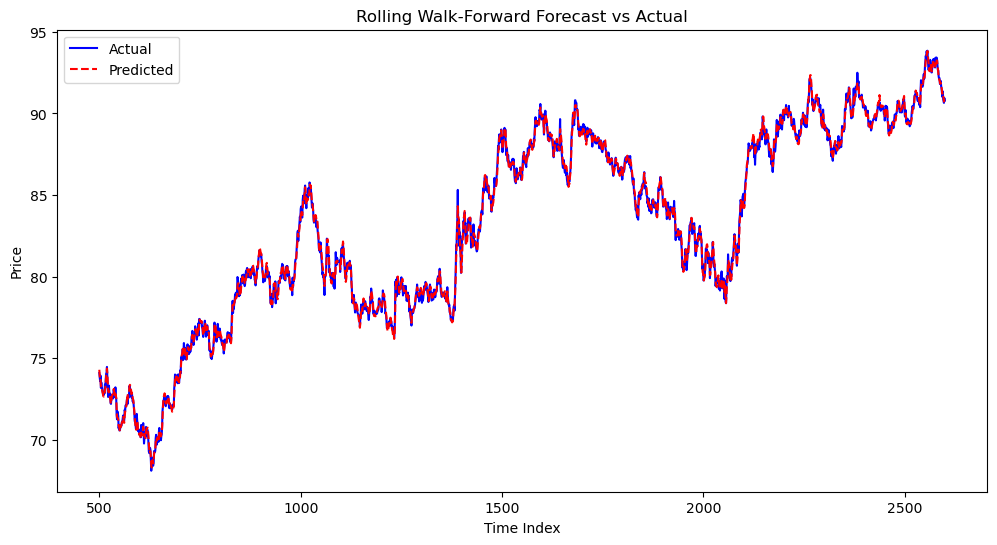

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'  # or try 'Deseasonalized_Day_high', etc.

X = df[features].values
y = df[target].values

# === Walk-forward params ===
train_window = 500   # how many samples in each rolling train set
test_window = 30     # how many samples to predict forward each step

lr = LinearRegression()

# Store results
all_preds, all_actuals, all_idx = [], [], []

for start in range(0, len(X) - train_window - test_window, test_window):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

# Convert to Series
y_actual_series = pd.Series(all_actuals, index=all_idx)
y_pred_series = pd.Series(all_preds, index=all_idx)

# === Metrics ===
mae = mean_absolute_error(y_actual_series, y_pred_series)
rmse = np.sqrt(mean_squared_error(y_actual_series, y_pred_series))
r2 = r2_score(y_actual_series, y_pred_series)

print(f"Rolling Walk-Forward MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Directional Accuracy
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

da = directional_accuracy(y_actual_series.values, y_pred_series.values)
print(f"Directional Accuracy: {da:.2f}%")



# Do same for each trained model

# === Plot results ===
plt.figure(figsize=(12,6))
plt.plot(y_actual_series.index, y_actual_series, label="Actual", color="blue")
plt.plot(y_pred_series.index, y_pred_series, label="Predicted", color="red", linestyle="dashed")
plt.title("Rolling Walk-Forward Forecast vs Actual")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.show()


In [6]:
import pickle

# Example for MLP
with open("lr_model.pkl", "wb") as f:
    pickle.dump(lr, f)

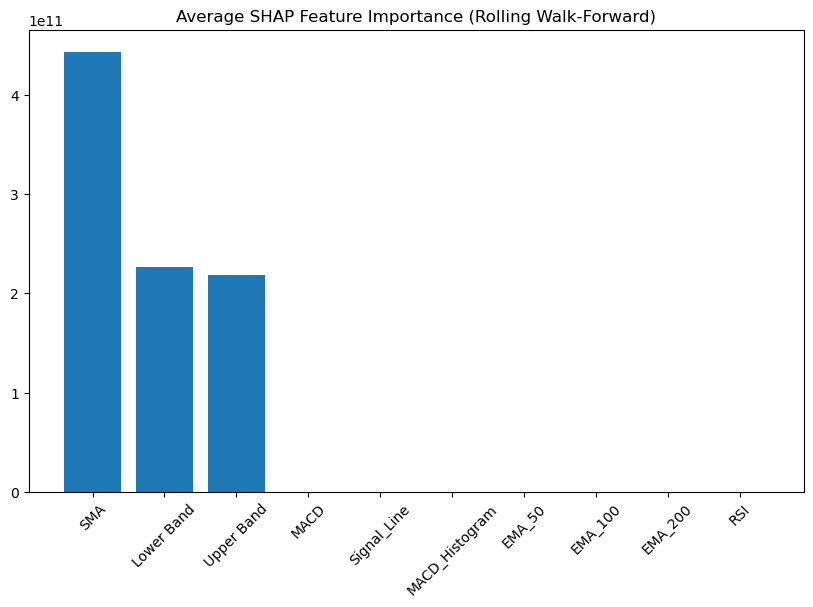

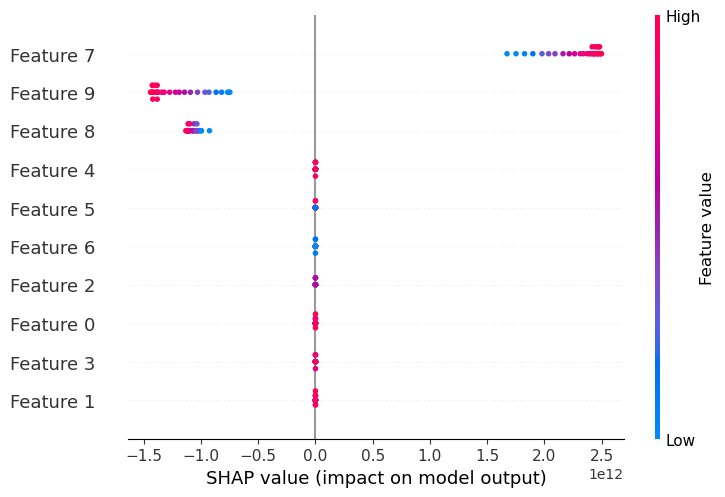

In [8]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
np.bool = np.bool_

# === SHAP on Rolling Walk-Forward ===
train_window = 500
test_window = 30
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]

X = df[features].values
y = df['Closing_price'].values

lr = LinearRegression()

all_shap_values = []
all_feature_importance = []

for start in range(0, len(X) - train_window - test_window, test_window):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test = X[end:end+test_window]
    
    # Fit
    lr.fit(X_train, y_train)
    
    # SHAP Explainer
    explainer = shap.Explainer(lr, X_train)
    shap_values = explainer(X_test)
    
    # Aggregate mean absolute shap values (feature importance for this window)
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    all_feature_importance.append(mean_abs_shap)

# Convert to array
all_feature_importance = np.array(all_feature_importance)

# === Plot Average Feature Importance Across Walk-Forward ===
mean_importance = all_feature_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()

# === Optional: Waterfall/Beeswarm for last window ===
shap.plots.beeswarm(shap_values, show=True)


## KNN

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  1.006689  1.110876 -2.994799  0.704708  0.073202    -0.015895   
1      2  0.609476  0.753464  0.242385  2.530686  0.387879    -0.001674   
2      3  1.258586  1.522365 -4.964493  1.655560  0.209849    -0.009326   
3      4  0.397327  0.521928 -1.213968  1.414233  0.147084    -0.007843   
4      5  0.936613  1.047894 -1.130388  2.689007  0.217243    -0.008661   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.246665  0.308752  0.652495  2.174340  0.342891    -0.002992   
66    67  0.236332  0.301210  0.514882  0.333844  0.060015    -0.007423   
67    68  0.334394  0.423485  0.575337  1.313747  0.323326    -0.002698   
68    69  1.770531  1.879230 -7.541910  2.058167  0.317686    -0.004981   
69    70  1.459332  1.547571 -1.707442 -0.128612 -0.023628    -0.011596   

    DirAcc(%)  
0   58.620690  
1   58.620690  
2   62.068966  
3   48.275862  
4   55.172414  
.. 

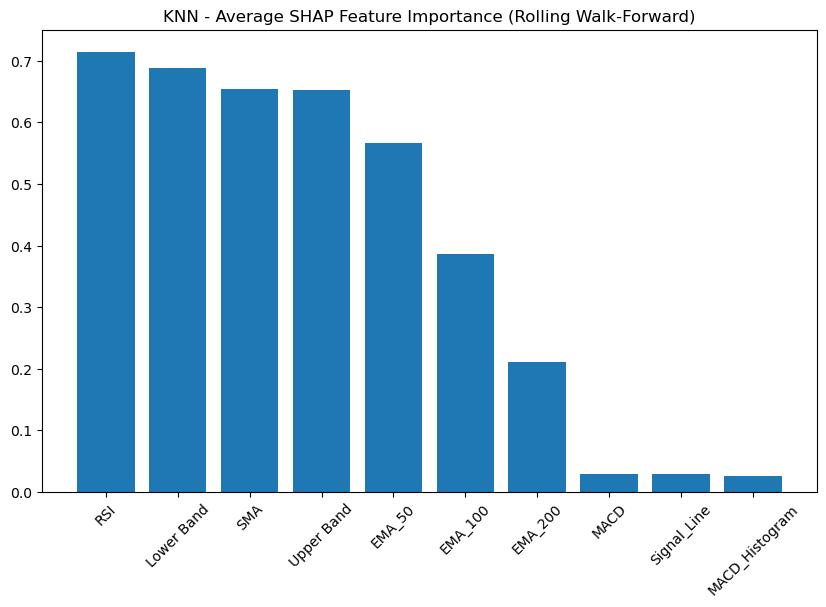

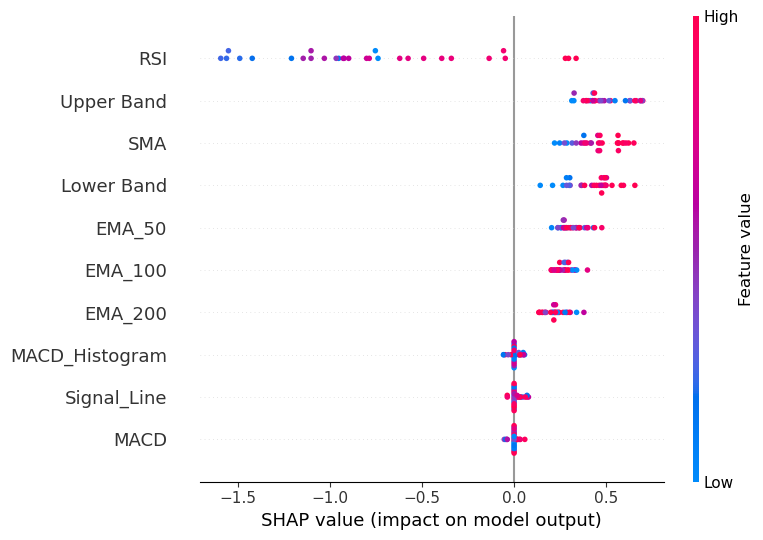

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
np.int = int

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

knn = KNeighborsRegressor(n_neighbors=5)

all_preds, all_actuals, all_idx = [], [], []
all_feature_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP (KernelExplainer) ---
    background = shap.sample(X_train, 100)  # subset for speed
    explainer = shap.KernelExplainer(knn.predict, background)
    shap_values = explainer.shap_values(X_test, nsamples=100)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_feature_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Predicted vs actual returns
    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    # Strategy: long if pred_return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics into DataFrame ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === Average SHAP importance ===
all_feature_importance = np.array(all_feature_importance)
mean_importance = all_feature_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("KNN - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()

# === SHAP Beeswarm for last window ===
shap.summary_plot(shap_values, X_test, feature_names=features)


## Catboost

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.299583  0.356358  0.588911  3.339648  0.460069    -0.002803   
1      2  0.315949  0.431830  0.751143  2.495776  0.397796    -0.002972   
2      3  0.338549  0.390651  0.607251  3.462702  0.408066    -0.004150   
3      4  0.255631  0.311040  0.213710  4.993316  0.499371    -0.001819   
4      5  0.874370  0.938110 -0.707386  5.161131  0.517343    -0.001527   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.260155  0.290507  0.692351  2.717266  0.430545    -0.002561   
66    67  0.197480  0.232204  0.711697  2.197400  0.441307    -0.002660   
67    68  0.187456  0.253309  0.848061  2.978306  0.379592    -0.005672   
68    69  1.402956  1.575494 -5.003834  1.730581  0.273242    -0.004519   
69    70  0.598931  0.659854  0.507787  1.125904  0.240765    -0.002640   

    DirAcc(%)  
0   86.206897  
1   68.965517  
2   72.413793  
3   82.758621  
4   72.413793  
.. 

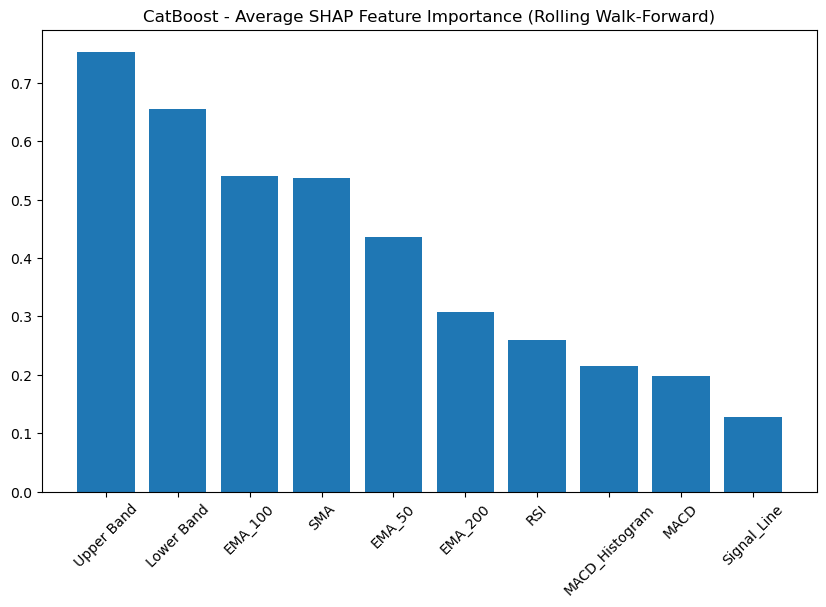

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

cat = CatBoostRegressor(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=0,
    random_seed=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Wrap into CatBoost Pool
    train_pool = Pool(X_train, y_train, feature_names=features)
    test_pool = Pool(X_test, y_test, feature_names=features)

    # Fit model
    cat.fit(train_pool)
    y_pred = cat.predict(test_pool)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values from CatBoost ---
    shap_values = cat.get_feature_importance(type="ShapValues", data=test_pool)
    # Last column of shap_values is expected_value, drop it
    shap_contribs = shap_values[:, :-1]
    mean_abs_shap = np.abs(shap_contribs).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

y_pred_cat = y_pred

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("CatBoost - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()


In [12]:
import pickle

# Example for MLP
with open("cat_model.pkl", "wb") as f:
    pickle.dump(cat, f)

## Gradient Boosting

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.653315  0.736478 -0.755831  2.013372  0.263240    -0.007552   
1      2  0.438979  0.623568  0.481092  1.170989  0.148081    -0.010807   
2      3  0.306146  0.412896  0.561249  3.362082  0.454955    -0.001941   
3      4  0.274787  0.333678  0.095089  2.089038  0.179849    -0.007442   
4      5  0.802016  0.922026 -0.649341  4.221932  0.351770    -0.010485   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.313189  0.362839  0.520079  2.558731  0.378221    -0.004424   
66    67  0.248379  0.310090  0.485855  2.157858  0.420469    -0.003346   
67    68  0.320841  0.373899  0.668963  3.864444  0.541145    -0.001331   
68    69  1.219854  1.401613 -3.751728  2.522473  0.419067    -0.004307   
69    70  0.567262  0.703732  0.440149  0.586018  0.102030    -0.005622   

    DirAcc(%)  
0   72.413793  
1   55.172414  
2   82.758621  
3   58.620690  
4   62.068966  
.. 

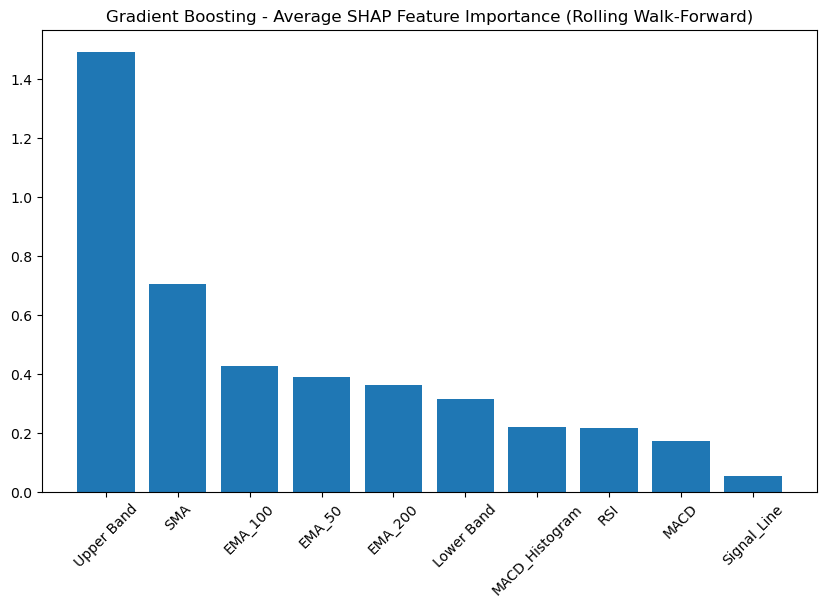

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

# === Prepare Data ===
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values ---
    explainer = shap.TreeExplainer(gbr)
    shap_values = explainer.shap_values(X_test)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("Gradient Boosting - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()


## Light GBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1662
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 10
[LightGBM] [Info] Start training from score 73.150089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

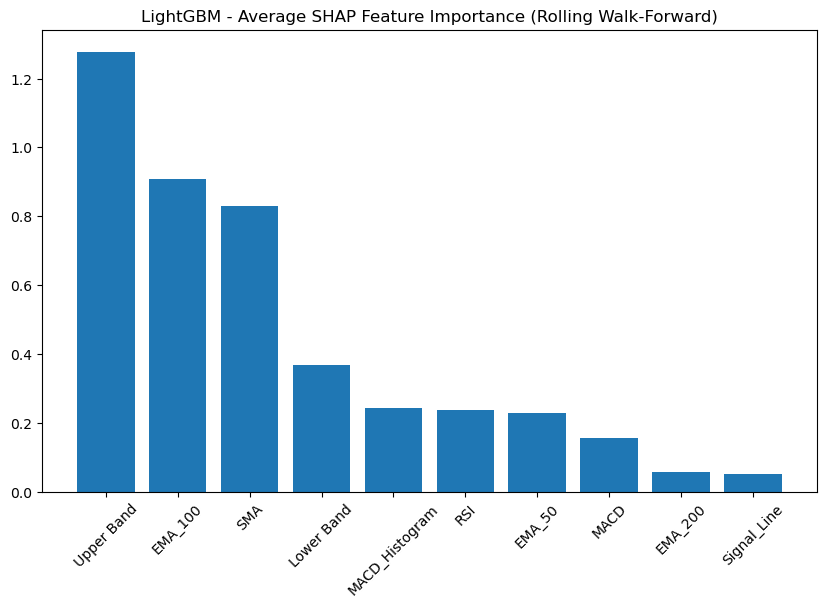

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
#df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Rolling walk-forward loop ===
for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values ---
    explainer = shap.TreeExplainer(lgbm)
    shap_values = explainer.shap_values(X_test)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    # Simple trading strategy: long if predicted return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

y_pred_lgb = y_pred

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("LightGBM - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()


In [15]:
import pickle

# Example for MLP
with open("lgbm_model.pkl", "wb") as f:
    pickle.dump(lgbm, f)

# MLP 


==== MLPRegressor ====
    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.239557  0.303777  0.701274  3.876146  0.526632    -0.002542   
1      2  0.226401  0.303399  0.877157  3.322438  0.558564    -0.000819   
2      3  0.185937  0.214644  0.881430  3.776528  0.462899    -0.002472   
3      4  0.206941  0.247811  0.500895  4.558947  0.458281    -0.003280   
4      5  0.307414  0.371876  0.731700  4.705645  0.437492    -0.008476   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.230316  0.297297  0.677802  2.885074  0.467513    -0.002321   
66    67  0.173637  0.218381  0.744999  2.423722  0.492966    -0.003475   
67    68  0.278973  0.338569  0.728568  3.563227  0.491207    -0.002075   
68    69  0.374792  0.435906  0.540400  3.155777  0.447214    -0.004307   
69    70  0.317074  0.364235  0.850024  1.487403  0.317605    -0.001748   

    DirAcc(%)  
0   89.655172  
1   86.206897  
2   79.310345  
3   82.7586

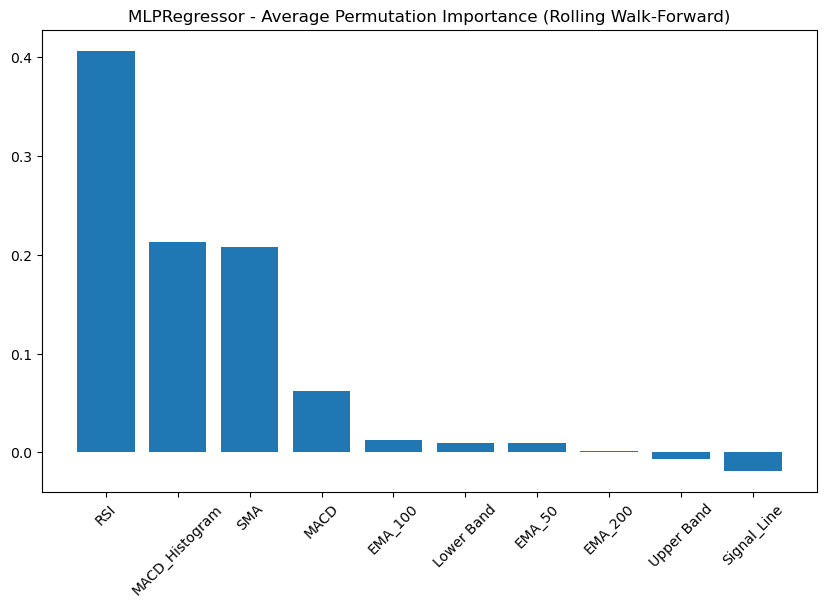


==== SVR ====
    Fold       MAE      RMSE         R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.482101  0.629645  -0.283381  1.004453  0.144412    -0.006710   
1      2  0.993267  1.241658  -1.057441 -1.533945 -0.200183    -0.024257   
2      3  0.553642  0.706465  -0.284451  0.418046  0.063208    -0.010687   
3      4  0.727339  0.867130  -5.111089 -2.436081 -0.310999    -0.025820   
4      5  0.944807  1.148770  -1.560294 -1.151912 -0.109110    -0.025333   
..   ...       ...       ...        ...       ...       ...          ...   
65    66  0.474905  0.602166  -0.321830  1.051700  0.130844    -0.009378   
66    67  0.396366  0.536288  -0.537823  0.273883  0.044531    -0.007984   
67    68  0.531876  0.714818  -0.209926  2.465662  0.309125    -0.007178   
68    69  3.729249  4.105258 -39.763938  0.192356  0.037962    -0.009190   
69    70  2.730802  2.913576  -8.596457 -1.382658 -0.216974    -0.019833   

    DirAcc(%)  
0   62.068966  
1   41.379310  
2   55.172414  
3   44.8

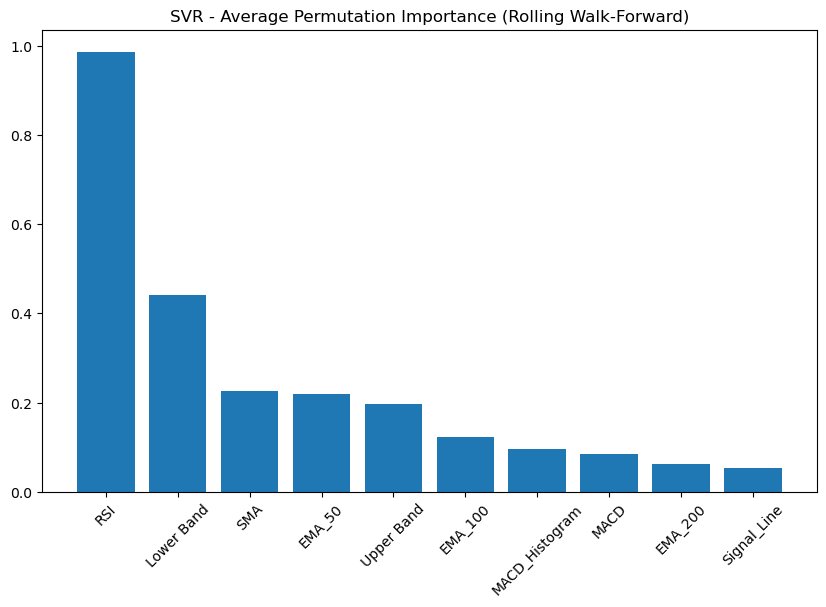

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

# Models
mlp = MLPRegressor(hidden_layer_sizes=(64,32),
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   random_state=42)

svm = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)

models = {
    "MLPRegressor": mlp,
    "SVR": svm
}

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

results = {}
all_model_preds = {}  # store final predictions for each model

# === Loop for each model ===
for model_name, model in models.items():
    all_preds, all_actuals, all_idx = [], [], []
    all_importance, all_metrics = [], []

    for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
        end = start + train_window
        X_train, y_train = X[start:end], y[start:end]
        X_test, y_test = X[end:end+test_window], y[end:end+test_window]

        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_preds.extend(y_pred)
        all_actuals.extend(y_test)
        all_idx.extend(range(end, end+test_window))

        # --- Feature Importance via Permutation (only works for some models)
        try:
            perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
            mean_importance = perm.importances_mean
            all_importance.append(mean_importance)
        except Exception:
            pass

        # --- Metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
        actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

        strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
        strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

        roi = strategy_returns.sum() * 100
        sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
        cumulative = (1 + strategy_returns).cumprod()
        drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
        max_dd = drawdown.min()

        da = directional_accuracy(y_test, y_pred)

        all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

    # Save results
    metrics_df = pd.DataFrame(all_metrics, columns=[
        'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
    ])
    results[model_name] = {
        "metrics": metrics_df,
        "avg_metrics": metrics_df.mean(),
        "importance": np.array(all_importance).mean(axis=0) if all_importance else None,
        "preds": np.array(all_preds),       # save predictions
        "actuals": np.array(all_actuals),   # save actuals
        "index": np.array(all_idx)
    }
    all_model_preds[model_name] = np.array(all_preds)

    # === Print metrics ===
    print(f"\n==== {model_name} ====")
    print(metrics_df)
    print("\nAverage performance across folds:")
    print(metrics_df.mean())

    # === Plot feature importance (if available) ===
    if results[model_name]["importance"] is not None:
        sorted_idx = np.argsort(results[model_name]["importance"])[::-1]
        plt.figure(figsize=(10,6))
        plt.bar(range(len(features)), results[model_name]["importance"][sorted_idx])
        plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
        plt.title(f"{model_name} - Average Permutation Importance (Rolling Walk-Forward)")
        plt.show()

# === Expose separate predictions for later usage (e.g. DM test) ===
y_pred_mlp = results["MLPRegressor"]["preds"]
y_pred_svr = results["SVR"]["preds"]
y_actual_series = results["MLPRegressor"]["actuals"]  # same across models


In [17]:
import pickle

# Example for MLP
with open("mlp_model.pkl", "wb") as f:
    pickle.dump(mlp, f)

In [18]:
import pickle

# Example for MLP
with open("svr_model.pkl", "wb") as f:
    pickle.dump(svm, f)

## Bilstm

    Fold        MAE       RMSE            R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  33.597830  33.603076  -3202.078207  0.000000  0.000000     0.000000   
1      2  32.104696  32.112353  -2096.318017  0.000000  0.000000     0.000000   
2      3  32.597237  32.602583  -3048.357792  0.521325  0.298796     0.000000   
3      4  30.398848  30.400181 -11400.191720 -0.199071 -0.034517    -0.007442   
4      5  30.319663  30.328613  -1693.525505  0.634637  0.223607     0.000000   
..   ...        ...        ...           ...       ...       ...          ...   
65    66  48.808838  48.810546 -14284.197515 -0.300157 -0.132193    -0.004424   
66    67  49.147710  49.150003 -10716.481986 -0.140736 -0.223607    -0.001407   
67    68  50.178262  50.179328 -23537.458643  1.140893  0.223607     0.000000   
68    69  53.192080  53.193522 -18439.901118  0.286065  0.080561    -0.006883   
69    70  51.545879  51.551396  -4670.793282  0.000000  0.000000     0.000000   

    DirAcc(%)  
0    0.0000

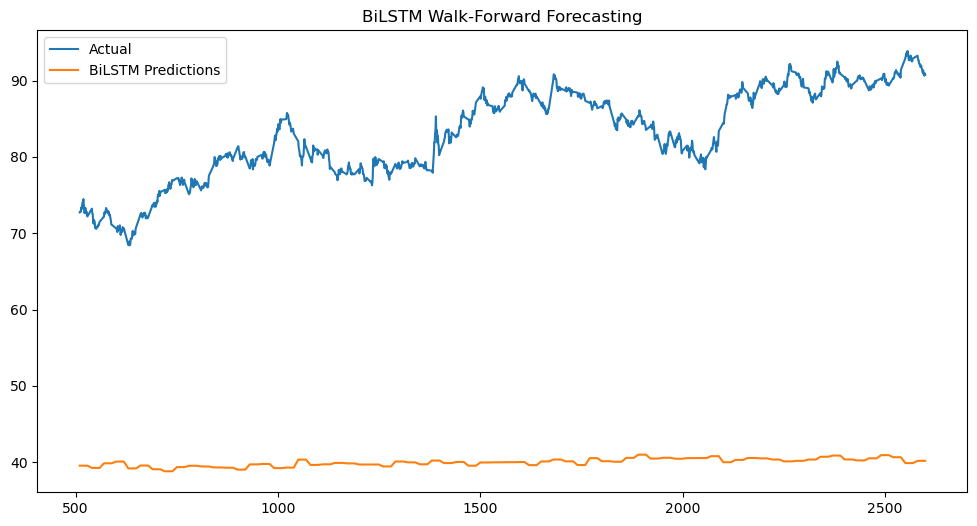

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

# ====================
# Prepare Data
# ====================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

# scale optional: you can normalize if needed
# ====================
# BiLSTM Model
# ====================
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(BiLSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, 1)  # *2 for bidirectional

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        return self.fc(out)

# ====================
# Helper Functions
# ====================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

def create_sequences(X, y, seq_len=10):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:(i+seq_len)])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

# ====================
# Walk-Forward Params
# ====================
train_window = 500
test_window = 30
seq_len = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds, all_actuals, all_idx, all_metrics = [], [], [], []

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train_raw, y_train_raw = X[start:end], y[start:end]
    X_test_raw, y_test_raw = X[end:end+test_window], y[end:end+test_window]

    # Create sequences
    X_train, y_train = create_sequences(X_train_raw, y_train_raw, seq_len)
    X_test, y_test = create_sequences(X_test_raw, y_test_raw, seq_len)

    train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).unsqueeze(-1))
    test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test).unsqueeze(-1))

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    # Init model
    model = BiLSTMRegressor(input_dim=X.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    model.train()
    for epoch in range(20):  # keep small for walk-forward
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Predict
    # Predict
    # Predict
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().squeeze().tolist()   # stay as Python list
            preds_list.extend(preds)
            actual_list.extend(yb.squeeze().tolist())



    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end+seq_len, end+seq_len+len(preds_list)))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)
    da = directional_accuracy(actual_list, preds_list)

    # Trading metrics
    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ====================
# Collect Results
# ====================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_bilstm = preds_list
# ====================
# Plot Predictions
# ====================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="BiLSTM Predictions")
plt.legend()
plt.title("BiLSTM Walk-Forward Forecasting")
plt.show()


## CNN

Shape: (2592, 30, 10) (2592,)
    Fold        MAE       RMSE          R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1   8.471427   8.786751 -102.033947 -2.183928 -0.192565    -0.037082   
1      2   5.203989   5.470616  -76.020909  1.480561  0.211848    -0.005112   
2      3   4.807691   4.893238 -193.599961 -0.349566 -0.036520    -0.017598   
3      4  14.173053  14.353564 -398.708860  0.241002  0.014920    -0.035103   
4      5  19.526517  19.540392 -517.985769 -0.174760 -0.054768    -0.006224   
..   ...        ...        ...         ...       ...       ...          ...   
64    65   4.443473   6.293962 -143.407793  1.392089  0.221442    -0.004828   
65    66   3.220667   4.064517  -87.334041 -0.371653 -0.087954    -0.010977   
66    67   3.638995   4.303011  -42.844331  0.961720  0.172558    -0.008680   
67    68   5.509171   6.973196 -116.613952  0.431284  0.051823    -0.018401   
68    69  15.880707  16.546763 -308.516850 -1.133838 -0.235973    -0.012790   

    DirAcc(%)  
0   3

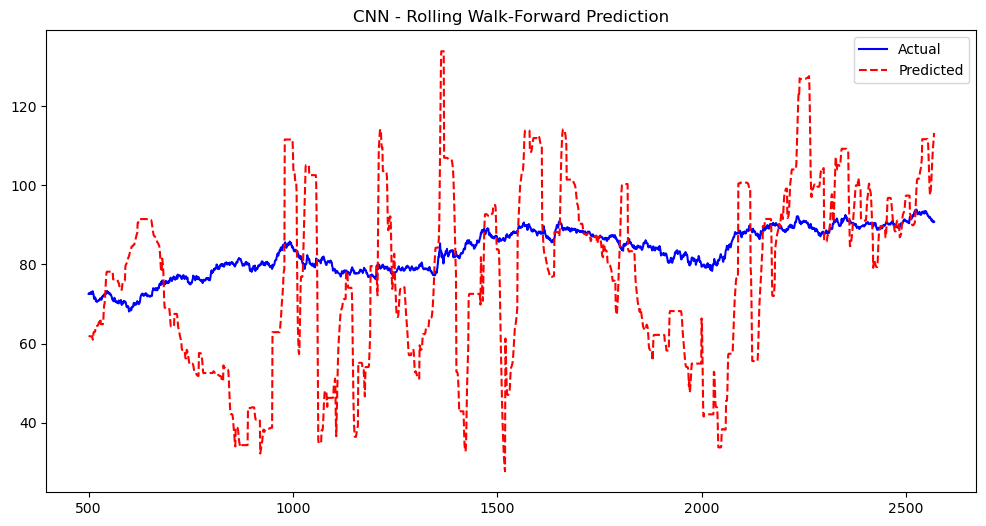

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # how many past days to use
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

# Function to build sequences
def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# CNN Model
# ===================
class CNN1D(nn.Module):
    def __init__(self, input_dim, lookback):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # input: (batch, lookback, features)
        x = x.permute(0, 2, 1)   # -> (batch, features, lookback)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = CNN1D(input_dim=X_train.shape[2], lookback=lookback).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):  # epochs per fold
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())


    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

y_pred_cnn = preds_list
# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("CNN - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## CNN- LSTM


Shape: (2592, 30, 10) (2592,)
    Fold       MAE      RMSE         R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  1.186901  1.450871  -1.809191 -1.914272 -0.133068    -0.038169   
1      2  0.642062  0.834648  -0.792848 -1.410466 -0.175264    -0.022687   
2      3  2.258596  2.285823 -41.465385 -1.565710 -0.114799    -0.026563   
3      4  3.553137  3.624943 -24.493329  1.822868  0.140816    -0.018696   
4      5  0.895388  1.240034  -1.090047  0.472615  0.139105    -0.003166   
..   ...       ...       ...        ...       ...       ...          ...   
64    65  2.669299  2.720201 -25.973947  0.160679  0.024145    -0.014986   
65    66  3.041999  3.072565 -49.479176 -0.653222 -0.104237    -0.013793   
66    67  2.935868  3.006744 -20.407277  1.254977  0.268522    -0.003966   
67    68  4.434824  4.481166 -47.571020  0.014606  0.001828    -0.012660   
68    69  3.529576  3.652461 -14.080975 -1.177721 -0.372277    -0.011726   

    DirAcc(%)  
0   44.827586  
1   34.482759  
2   31.03

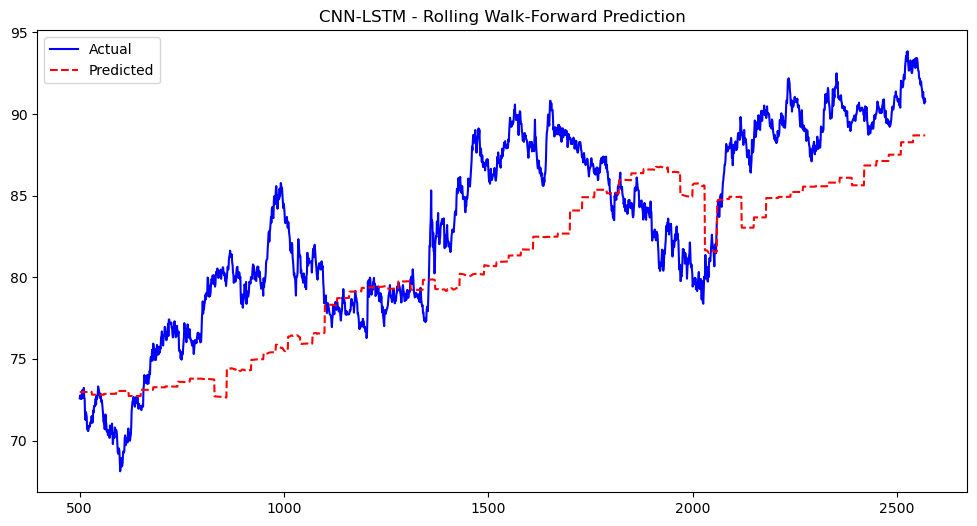

In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # days of history per sample
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# CNN-LSTM Model
# ===================
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Input shape: (batch, lookback, features)
        x = x.permute(0, 2, 1)         # -> (batch, features, lookback)
        x = self.conv1(x)              # -> (batch, 32, lookback-2)
        x = self.relu(x)
        x = x.permute(0, 2, 1)         # -> (batch, seq_len, 32)
        out, _ = self.lstm(x)          # -> (batch, seq_len, hidden_dim)
        out = out[:, -1, :]            # take last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = CNN_LSTM(input_dim=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())

    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("CNN-LSTM - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## GRU

Shape: (2592, 30, 10) (2592,)
    Fold       MAE      RMSE         R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.862285  0.972784  -0.262864 -0.557394 -0.042352    -0.027995   
1      2  0.654897  0.849015  -0.855100 -1.155812 -0.154745    -0.018614   
2      3  2.364850  2.390818 -45.456129 -0.966872 -0.069768    -0.026563   
3      4  3.687443  3.756641 -26.379388  0.786027  0.050130    -0.035103   
4      5  1.260262  1.525316  -2.162340  0.785444  0.244294    -0.003087   
..   ...       ...       ...        ...       ...       ...          ...   
64    65  2.861790  2.909275 -29.854041 -1.246475 -0.181213    -0.016039   
65    66  2.789035  2.822313 -41.591264 -1.133585 -0.156947    -0.018541   
66    67  4.271700  4.320740 -43.206367  0.884696  0.158304    -0.007777   
67    68  5.859612  5.894720 -83.046862  0.330869  0.045100    -0.007718   
68    69  3.498684  3.622057 -13.830941 -1.919898 -0.500924    -0.019045   

    DirAcc(%)  
0   51.724138  
1   41.379310  
2   37.93

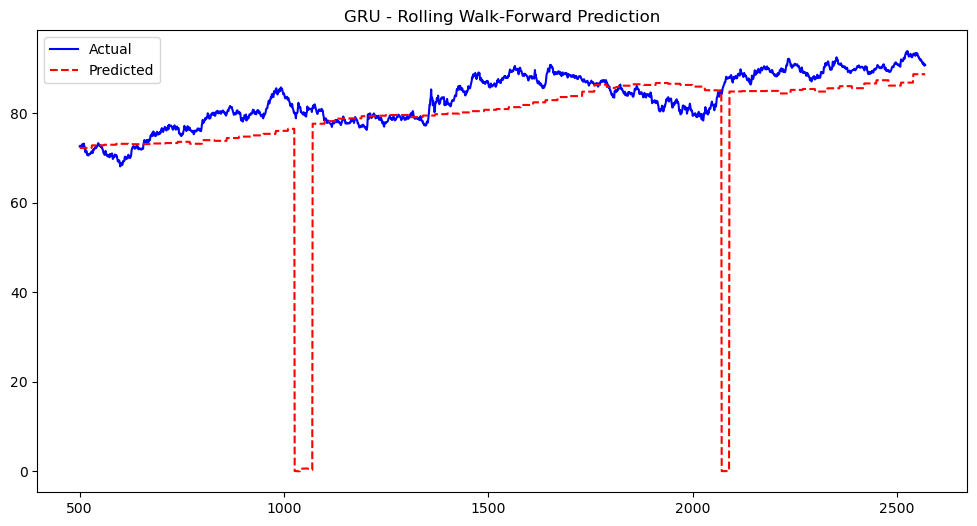

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # how many past days per sequence
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# GRU Model
# ===================
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Input shape: (batch, lookback, features)
        out, _ = self.gru(x)           # (batch, seq_len, hidden_dim)
        out = out[:, -1, :]            # take last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = GRUModel(input_dim=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):  # epochs per fold
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())

    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_gru = preds_list
# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("GRU - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## LSTM


Shape: (2592, 30, 10) (2592,)
    Fold       MAE      RMSE         R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  1.042590  1.313017  -1.300723  1.548045  0.148485    -0.016250   
1      2  0.636978  0.828613  -0.767014 -0.834766 -0.112398    -0.018614   
2      3  2.350226  2.376672 -44.908024  1.007629  0.075130    -0.018849   
3      4  3.720060  3.788238 -26.841899  1.177710  0.083233    -0.021690   
4      5  1.248971  1.517525  -2.130116  0.247891  0.070089    -0.003166   
..   ...       ...       ...        ...       ...       ...          ...   
64    65  3.003327  3.048297 -32.873264 -1.116770 -0.162709    -0.014761   
65    66  2.855208  2.887562 -43.583358 -0.928116 -0.136524    -0.016512   
66    67  2.570951  2.650410 -15.633920  0.953589  0.170828    -0.007093   
67    68  4.186275  4.234537 -42.371753  0.467902  0.062990    -0.005788   
68    69  3.401963  3.527568 -13.067240 -2.308012 -0.549106    -0.022852   

    DirAcc(%)  
0   58.620690  
1   44.827586  
2   44.82

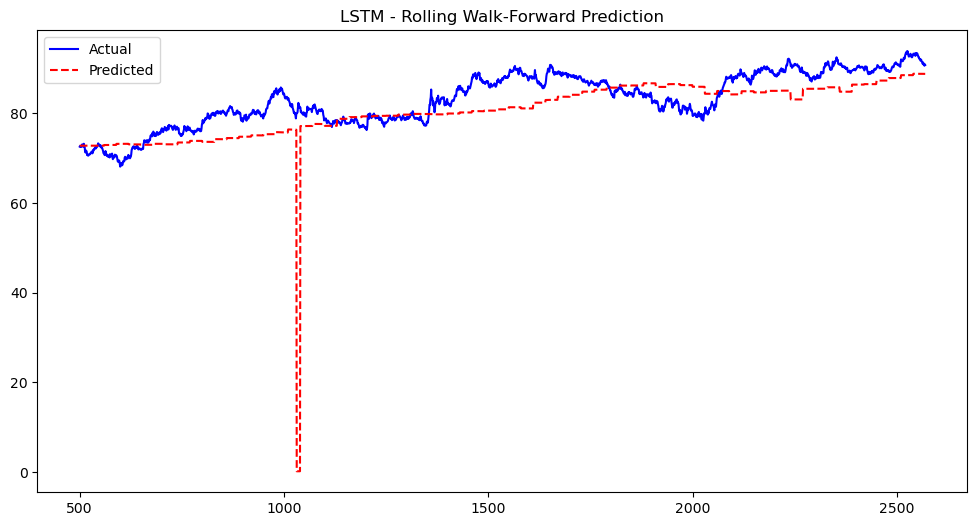

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # how many past days per sequence
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# LSTM Model
# ===================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Input shape: (batch, lookback, features)
        out, _ = self.lstm(x)          # (batch, seq_len, hidden_dim)
        out = out[:, -1, :]            # take last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = LSTMModel(input_dim=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):  # epochs per fold
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())

    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

y_pred_lstm = preds_list

# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("LSTM - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## PROPHET

15:57:51 - cmdstanpy - INFO - Chain [1] start processing
15:57:52 - cmdstanpy - INFO - Chain [1] done processing
15:57:53 - cmdstanpy - INFO - Chain [1] start processing
15:57:53 - cmdstanpy - INFO - Chain [1] done processing
15:57:54 - cmdstanpy - INFO - Chain [1] start processing
15:57:55 - cmdstanpy - INFO - Chain [1] done processing
15:57:55 - cmdstanpy - INFO - Chain [1] start processing
15:57:56 - cmdstanpy - INFO - Chain [1] done processing
15:57:56 - cmdstanpy - INFO - Chain [1] start processing
15:57:57 - cmdstanpy - INFO - Chain [1] done processing
15:57:57 - cmdstanpy - INFO - Chain [1] start processing
15:57:58 - cmdstanpy - INFO - Chain [1] done processing
15:57:58 - cmdstanpy - INFO - Chain [1] start processing
15:57:59 - cmdstanpy - INFO - Chain [1] done processing
15:57:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:00 - cmdstanpy - INFO - Chain [1] done processing
15:58:00 - cmdstanpy - INFO - Chain [1] start processing
15:58:01 - cmdstanpy - INFO - Chain [1]


=== Prophet WITH Regressors ===
    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.350441  0.411327  0.452305  3.664558  0.517747    -0.001042   
1      2  0.376168  0.439821  0.741848  4.108285  0.574236    -0.002117   
2      3  0.262450  0.310842  0.751335  4.071810  0.522438    -0.001708   
3      4  0.404461  0.431539 -0.513524  5.121733  0.517034    -0.001819   
4      5  0.198872  0.242528  0.885883  5.235183  0.524448    -0.001840   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.202148  0.276925  0.720446  3.101652  0.494998    -0.002321   
66    67  0.967010  1.134205 -5.878503  2.269270  0.445300    -0.002677   
67    68  0.882147  0.955340 -1.161148  3.590890  0.496056    -0.002075   
68    69  0.907533  0.975924 -1.303708  3.451576  0.514549    -0.004307   
69    70  0.835632  0.930070  0.022112  1.910600  0.369232    -0.001748   

    DirAcc(%)  
0   86.206897  
1   82.758621  
2   79.310345  
3 

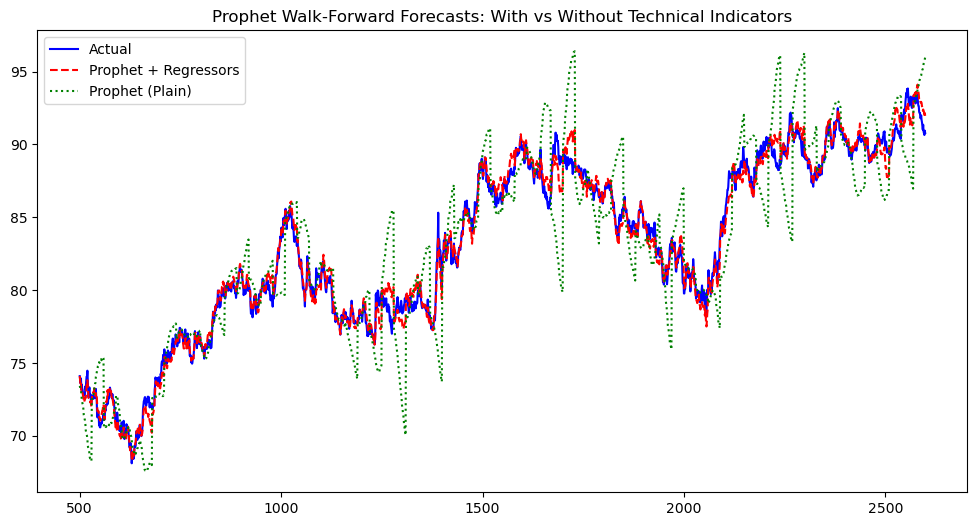

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ===================
# Parameters
# ===================
train_window = 500
test_window = 30

# Prophet requires 'ds' and 'y'
df_prophet = df[['Date', 'Closing_price',
                 'EMA_100', 'EMA_200', 'EMA_50',
                 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
                 'SMA', 'Upper Band', 'Lower Band']].copy()

df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Closing_price': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Regressors to add
regressors = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]

# ===================
# Utility function
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

def evaluate_strategy(y_test, y_pred):
    """Compute metrics for forecasts"""
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(y_test, y_pred)

    return [mae, rmse, r2, roi, sharpe, max_dd, da]

# ===================
# Walk-forward Prophet with & without regressors
# ===================
metrics_with, metrics_without = [], []
all_preds_with, all_preds_without = [], []
all_actuals, all_idx = [], []

for fold, start in enumerate(range(0, len(df_prophet) - train_window - test_window, test_window), 1):
    end = start + train_window
    train = df_prophet.iloc[start:end]
    test = df_prophet.iloc[end:end+test_window]

    # ---- Prophet WITH regressors ----
    model_with = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    for reg in regressors:
        model_with.add_regressor(reg)
    model_with.fit(train[['ds', 'y'] + regressors])

    future_with = test[['ds'] + regressors].copy()
    forecast_with = model_with.predict(future_with)

    y_pred_with = forecast_with['yhat'].values
    y_test = test['y'].values

    metrics_with.append([fold] + evaluate_strategy(y_test, y_pred_with))
    all_preds_with.extend(y_pred_with)

    # ---- Prophet WITHOUT regressors ----
    model_plain = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    model_plain.fit(train[['ds', 'y']])

    future_plain = test[['ds']].copy()
    forecast_plain = model_plain.predict(future_plain)

    y_pred_plain = forecast_plain['yhat'].values
    metrics_without.append([fold] + evaluate_strategy(y_test, y_pred_plain))
    all_preds_without.extend(y_pred_plain)

    # Save actuals
    all_actuals.extend(y_test)
    all_idx.extend(test.index)

# ===================
# Collect metrics
# ===================
cols = ['Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)']
metrics_with_df = pd.DataFrame(metrics_with, columns=cols)
metrics_without_df = pd.DataFrame(metrics_without, columns=cols)

print("\n=== Prophet WITH Regressors ===")
print(metrics_with_df)
print("\nAverage performance:")
print(metrics_with_df.mean())

print("\n=== Prophet WITHOUT Regressors ===")
print(metrics_without_df)
print("\nAverage performance:")
print(metrics_without_df.mean())

# ===================
# Plot comparison
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds_with, label="Prophet + Regressors", color="red", linestyle="dashed")
plt.plot(all_idx, all_preds_without, label="Prophet (Plain)", color="green", linestyle="dotted")
plt.title("Prophet Walk-Forward Forecasts: With vs Without Technical Indicators")
plt.legend()
plt.show()


16:00:48 - cmdstanpy - INFO - Chain [1] start processing
16:00:49 - cmdstanpy - INFO - Chain [1] done processing
16:00:49 - cmdstanpy - INFO - Chain [1] start processing
16:00:50 - cmdstanpy - INFO - Chain [1] done processing
16:00:50 - cmdstanpy - INFO - Chain [1] start processing
16:00:51 - cmdstanpy - INFO - Chain [1] done processing
16:00:51 - cmdstanpy - INFO - Chain [1] start processing
16:00:52 - cmdstanpy - INFO - Chain [1] done processing
16:00:52 - cmdstanpy - INFO - Chain [1] start processing
16:00:53 - cmdstanpy - INFO - Chain [1] done processing
16:00:53 - cmdstanpy - INFO - Chain [1] start processing
16:00:54 - cmdstanpy - INFO - Chain [1] done processing
16:00:54 - cmdstanpy - INFO - Chain [1] start processing
16:00:56 - cmdstanpy - INFO - Chain [1] done processing
16:00:56 - cmdstanpy - INFO - Chain [1] start processing
16:00:57 - cmdstanpy - INFO - Chain [1] done processing
16:00:57 - cmdstanpy - INFO - Chain [1] start processing
16:00:58 - cmdstanpy - INFO - Chain [1]

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.335941  0.397982  0.487268  3.664558  0.517747    -0.001042   
1      2  0.417937  0.487528  0.682807  4.108285  0.574236    -0.002117   
2      3  0.255207  0.307102  0.757282  4.071810  0.522438    -0.001708   
3      4  0.444007  0.471940 -0.810189  5.121733  0.517034    -0.001819   
4      5  0.208999  0.253449  0.875375  5.235183  0.524448    -0.001840   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.195039  0.262285  0.749222  3.101652  0.494998    -0.002321   
66    67  0.931808  1.085482 -5.300221  2.269270  0.445300    -0.002677   
67    68  0.903765  0.975914 -1.255233  3.590890  0.496056    -0.002075   
68    69  0.931040  1.001638 -1.426705  3.451576  0.514549    -0.004307   
69    70  0.824703  0.918551  0.046184  1.910600  0.369232    -0.001748   

    DirAcc(%)  
0   86.206897  
1   82.758621  
2   79.310345  
3   86.206897  
4   72.413793  
.. 

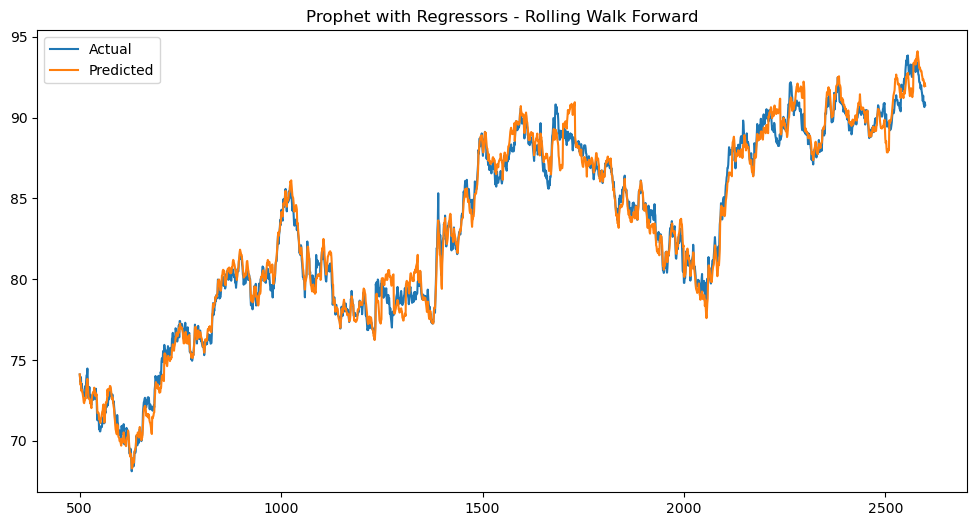

In [25]:
 
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Prepare data ===
# df = your dataframe
#df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

# Prophet requires "ds" (date) and "y" (target)
prophet_df = df[['Date', target] + features].rename(columns={'Date': 'ds', target: 'y'})

# === Walk-forward parameters ===
train_window = 500
test_window = 30

all_preds, all_actuals, all_idx = [], [], []
all_metrics = []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Walk-forward loop ===
for fold, start in enumerate(range(0, len(prophet_df) - train_window - test_window, test_window), 1):
    end = start + train_window
    train_df = prophet_df.iloc[start:end]
    test_df = prophet_df.iloc[end:end+test_window]

    # Prophet model
    model = Prophet(
        daily_seasonality=False,
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=5
    )
    for f in features:
        model.add_regressor(f)

    model.fit(train_df)

    forecast = model.predict(test_df)
    y_pred = forecast['yhat'].values
    y_test = test_df['y'].values

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(test_df.index)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_prophet = y_pred
# === Plot actual vs predicted ===
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="Predicted")
plt.legend()
plt.title("Prophet with Regressors - Rolling Walk Forward")
plt.show()


## SARIMA

Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood o

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.256803  0.369542  0.557929  3.816889  0.514460    -0.002542   
1      2  0.212353  0.254507  0.913559  4.151601  0.582734    -0.002117   
2      3  0.477039  0.542406  0.242846  3.877705  0.486580    -0.001941   
3      4  0.702986  0.789663 -4.067965  4.561333  0.426376    -0.005588   
4      5  0.322209  0.373712  0.729044  5.287980  0.531504    -0.001840   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.365507  0.460517  0.226904  3.103341  0.495335    -0.002321   
66    67  0.345420  0.403801  0.128144  2.171774  0.411691    -0.002677   
67    68  0.524026  0.619499  0.091240  3.598875  0.497441    -0.002075   
68    69  0.618876  0.659026 -0.050509  3.451576  0.514549    -0.004307   
69    70  0.563068  0.621681  0.563088  1.914790  0.370160    -0.001748   

    DirAcc(%)  
0   89.655172  
1   86.206897  
2   75.862069  
3   82.758621  
4   75.862069  
.. 

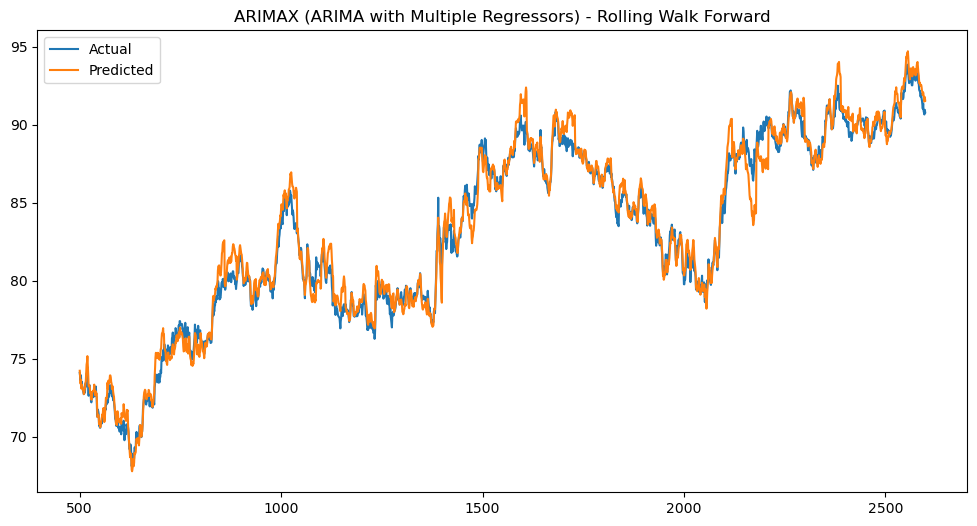

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare data ===
# df = your dataframe
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

all_preds, all_actuals, all_idx = [], [], []
all_metrics = []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Walk-forward loop ===
for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit ARIMAX model (simple ARIMA(1,1,1) here, can tune with auto_arima)
    try:
        model = SARIMAX(y_train,
                        exog=X_train,
                        order=(1, 1, 1),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)

        y_pred = results.predict(start=len(y_train),
                                 end=len(y_train)+len(y_test)-1,
                                 exog=X_test)

    except Exception as e:
        print(f"Fold {fold} failed: {e}")
        continue

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === Plot actual vs predicted ===
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="Predicted")
plt.legend()
plt.title("ARIMAX (ARIMA with Multiple Regressors) - Rolling Walk Forward")
plt.show()


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood o

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.282118  0.386444  0.516567  3.816889  0.514460    -0.002542   
1      2  0.221680  0.263090  0.907630  3.992492  0.549020    -0.002972   
2      3  0.285253  0.347567  0.689105  3.877705  0.486580    -0.001941   
3      4  0.688310  0.763621 -3.739214  5.120169  0.514190    -0.001819   
4      5  0.395991  0.446716  0.612842  5.471979  0.558814    -0.000548   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.372415  0.476341  0.172860  3.103341  0.495335    -0.002321   
66    67  0.355871  0.417286  0.068938  2.171774  0.411691    -0.002677   
67    68  0.526020  0.619703  0.090642  3.726590  0.517380    -0.002075   
68    69  0.686457  0.723545 -0.266269  3.459651  0.516072    -0.004307   
69    70  0.587067  0.641001  0.535511  1.910600  0.369232    -0.001748   

    DirAcc(%)  
0   89.655172  
1   82.758621  
2   75.862069  
3   86.206897  
4   79.310345  
.. 

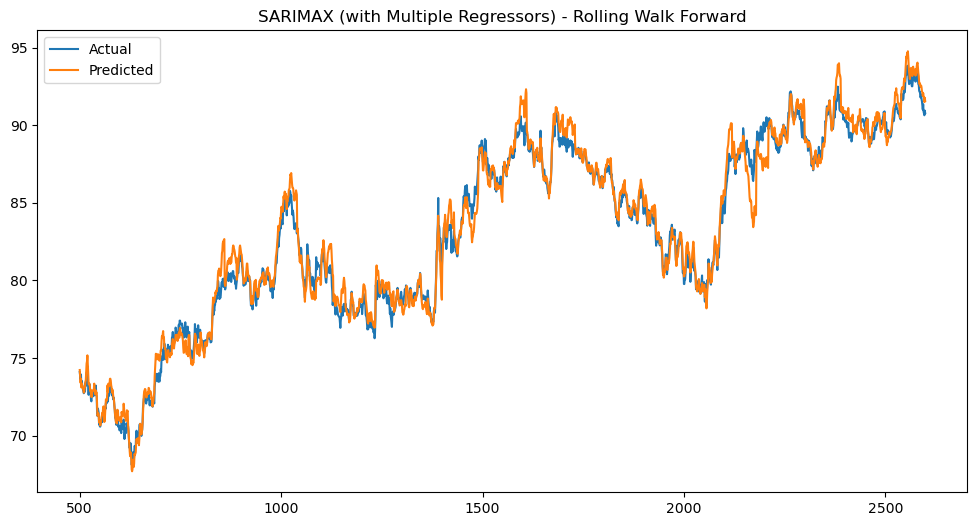

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare data ===
# df = your dataframe
#df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

all_preds, all_actuals, all_idx = [], [], []
all_metrics = []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Walk-forward loop ===
for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    try:
        # SARIMAX with seasonality (set seasonal_order=(P,D,Q,s))
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=(1, 1, 1),                # ARIMA(p,d,q)
            seasonal_order=(1, 0, 1, 12),   # SARIMA(P,D,Q,s) -> here s=12 (monthly seasonality example)
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)

        y_pred = results.predict(
            start=len(y_train),
            end=len(y_train)+len(y_test)-1,
            exog=X_test
        )

    except Exception as e:
        print(f"Fold {fold} failed: {e}")
        continue

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_sarima = y_pred
# === Plot actual vs predicted ===
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="Predicted")
plt.legend()
plt.title("SARIMAX (with Multiple Regressors) - Rolling Walk Forward")
plt.show()


## Diebold–Mariano (DM) test i

In [28]:
from itertools import combinations
from scipy import stats

# ======================================
# Helper: Diebold-Mariano Test
# ======================================
def diebold_mariano(y_true, y_pred1, y_pred2, crit="MSE"):
    e1 = y_true - y_pred1
    e2 = y_true - y_pred2

    if crit.upper() == "MSE":
        d = e1**2 - e2**2
    elif crit.upper() == "MAE":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")

    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))
    return dm_stat, p_value

# ======================================
# Step 1 – Collect predictions
# ======================================
# Suppose after each model you save predictions on the SAME test folds:
# y_actual_series = actual values (same for all models!)
# Store each model's preds in a dict:

all_model_preds = {
    "LinearRegression": y_pred_lr,     # np.array or pd.Series
    "CatBoost": y_pred_cat,
    "LightGBM": y_pred_lgb,
    "MLP": y_pred_mlp,
    "SVM": y_pred_svr,
    "BiLSTM": y_pred_bilstm,
    "GRU": y_pred_gru,
    "LSTM": y_pred_lstm,
    "CNN": y_pred_cnn,
    "Prophet": y_pred_prophet,
    "SARIMA": y_pred_sarima
}

# Make sure all are aligned with actuals
y_true = np.array(y_actual_series)

# ======================================
# Step 2 – Run DM tests across all pairs
# ======================================
dm_results = []

for (m1, m2) in combinations(all_model_preds.keys(), 2):
    y1 = np.array(all_model_preds[m1])
    y2 = np.array(all_model_preds[m2])

    # Align lengths
    min_len = min(len(y_true), len(y1), len(y2))
    y_true_aligned = y_true[-min_len:]
    y1, y2 = y1[-min_len:], y2[-min_len:]

    dm_stat, p_value = diebold_mariano(y_true_aligned, y1, y2, crit="MSE")
    dm_results.append([m1, m2, dm_stat, p_value])

dm_df = pd.DataFrame(dm_results, columns=["Model 1", "Model 2", "DM Stat", "p-value"])
print("\n=== Diebold-Mariano Test Results ===")
print(dm_df)

# ======================================
# Step 3 – Average performance summary
# ======================================
perf_summary = []
for name, preds in all_model_preds.items():
    preds = np.array(preds)
    min_len = min(len(y_true), len(preds))
    y_t, y_p = y_true[-min_len:], preds[-min_len:]

    mae = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    r2 = r2_score(y_t, y_p)

    # Trading metrics
    pred_returns = pd.Series(y_p).pct_change().fillna(0)
    actual_returns = pd.Series(y_t).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    def directional_accuracy(actual, predicted):
        actual_diff = np.diff(actual)
        pred_diff = np.diff(predicted)
        return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

    da = directional_accuracy(y_t, y_p)

    perf_summary.append([name, mae, rmse, r2, roi, sharpe, max_dd, da])

perf_df = pd.DataFrame(perf_summary, columns=[
    "Model", "MAE", "RMSE", "R2", "ROI(%)", "Sharpe", "MaxDrawdown", "DirAcc(%)"
])

print("\n=== Average Performance Across Models ===")
print(perf_df.sort_values(by="R2", ascending=False))



=== Diebold-Mariano Test Results ===
             Model 1   Model 2     DM Stat       p-value
0   LinearRegression  CatBoost   11.535357  0.000000e+00
1   LinearRegression  LightGBM   10.201111  0.000000e+00
2   LinearRegression       MLP   16.938065  0.000000e+00
3   LinearRegression       SVM   -5.169482  2.347438e-07
4   LinearRegression    BiLSTM -146.816299  0.000000e+00
5   LinearRegression       GRU   -7.585992  3.308465e-14
6   LinearRegression      LSTM   -7.242077  4.418688e-13
7   LinearRegression       CNN  -11.512755  0.000000e+00
8   LinearRegression   Prophet    8.523792  0.000000e+00
9   LinearRegression    SARIMA   10.390357  0.000000e+00
10          CatBoost  LightGBM   -1.099276  2.716478e-01
11          CatBoost       MLP    4.983880  6.232175e-07
12          CatBoost       SVM   -8.176979  2.220446e-16
13          CatBoost    BiLSTM -148.810426  0.000000e+00
14          CatBoost       GRU  -11.135339  0.000000e+00
15          CatBoost      LSTM  -10.908832  0.0000

In [29]:
# === Save test set for reuse ===
test_set = df.iloc[end:end+test_window].copy()

# Save to CSV
test_set.to_csv("forex_test_set.csv", index=False)

# Or save as pickle (preserves dtypes better)
import pickle
with open("forex_test_set.pkl", "wb") as f:
    pickle.dump(test_set, f)

print("✅ Test set saved: forex_test_set.csv and forex_test_set.pkl")


✅ Test set saved: forex_test_set.csv and forex_test_set.pkl
